In [1]:
%load_ext autoreload
%autoreload 2    

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.tree import *
from spatial_scene_grammars.sampling import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

Unconditional grammar outputs look like this:

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


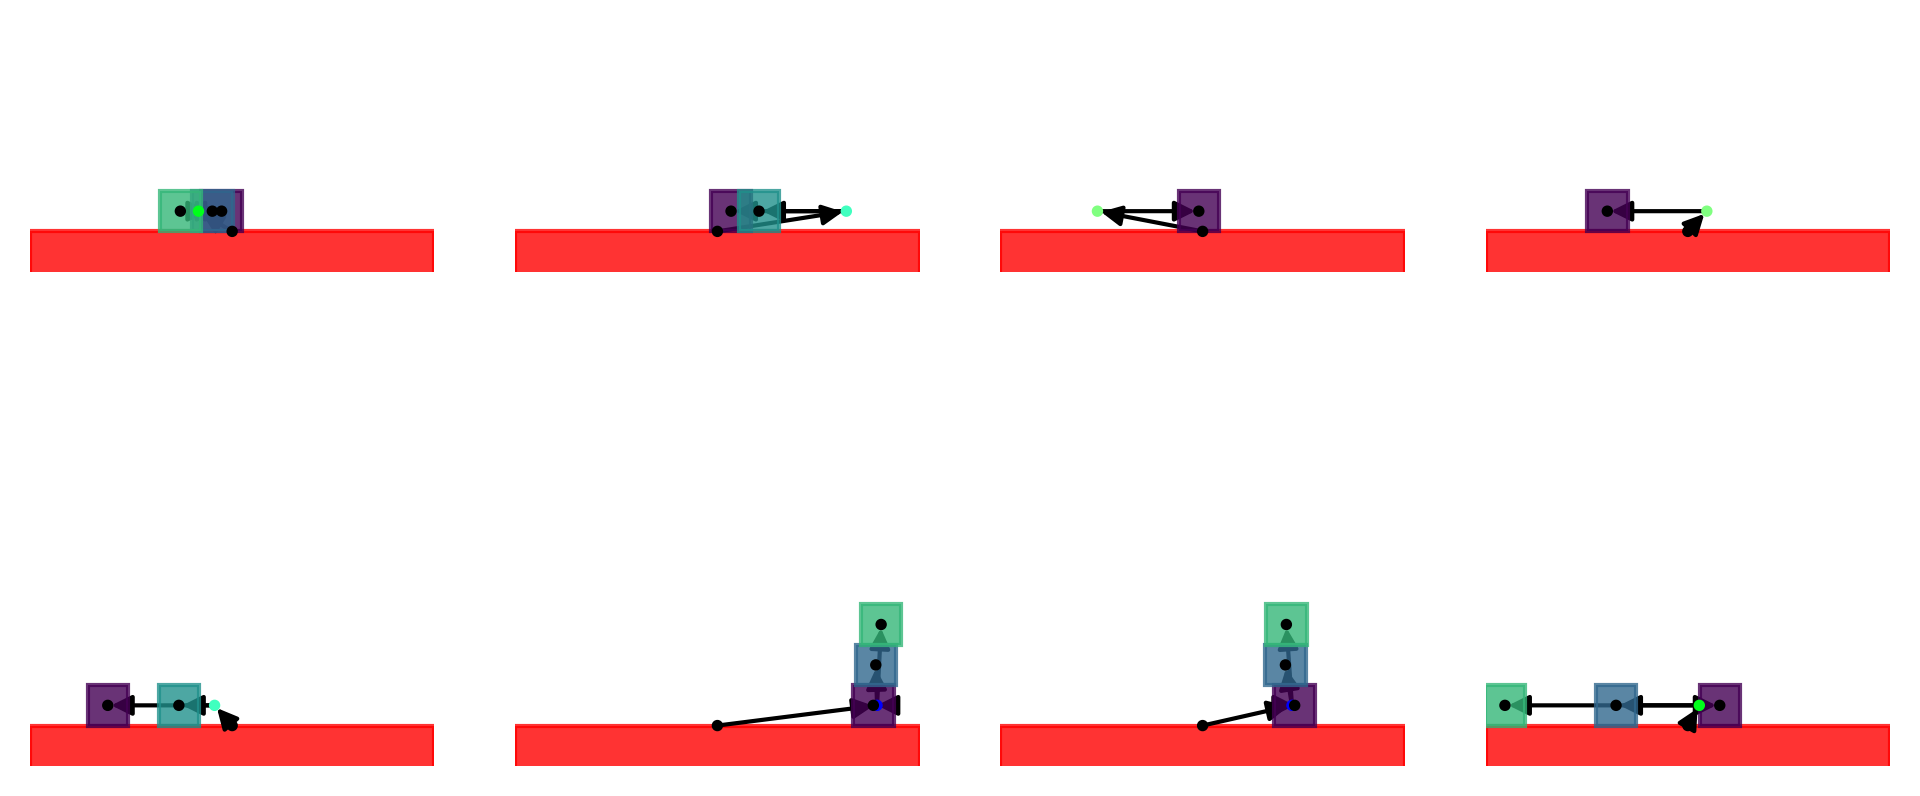

In [2]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(41)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = SceneTree.forward_sample_from_root_type(
                Ground, {"xy": torch.tensor([0., 0.])})
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

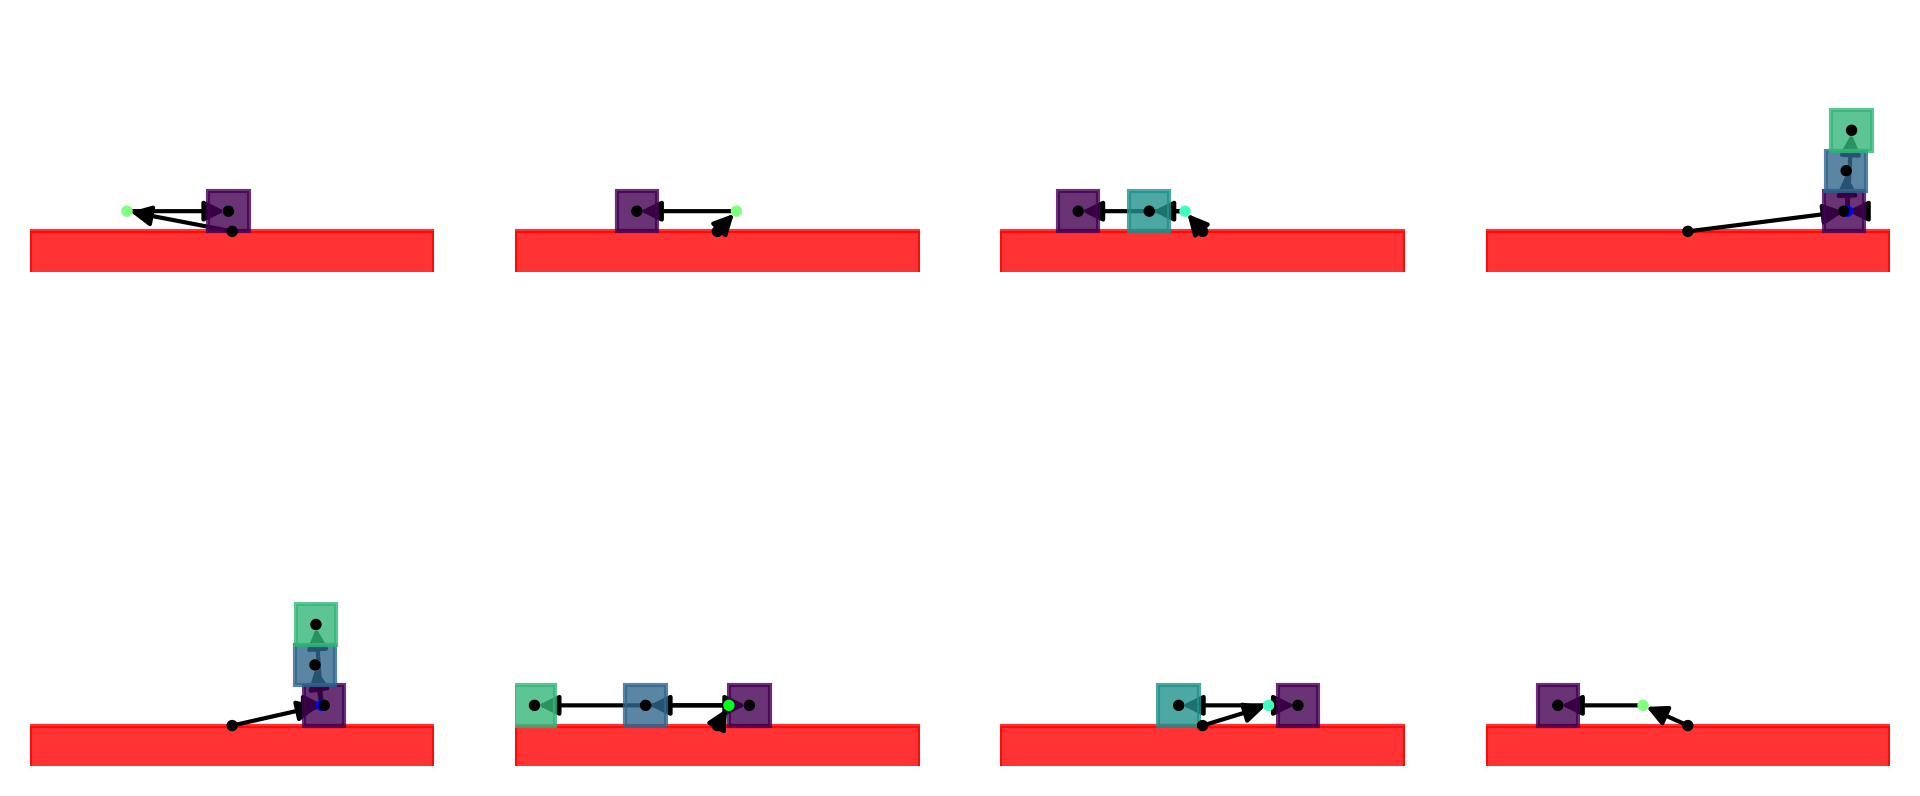

In [3]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(41)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict={
                "xy": torch.tensor([0., 0.])
            },
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

The "meta" ("hyper"? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(325.9838, 711.2962, -16.899900000000002, 385.2799)

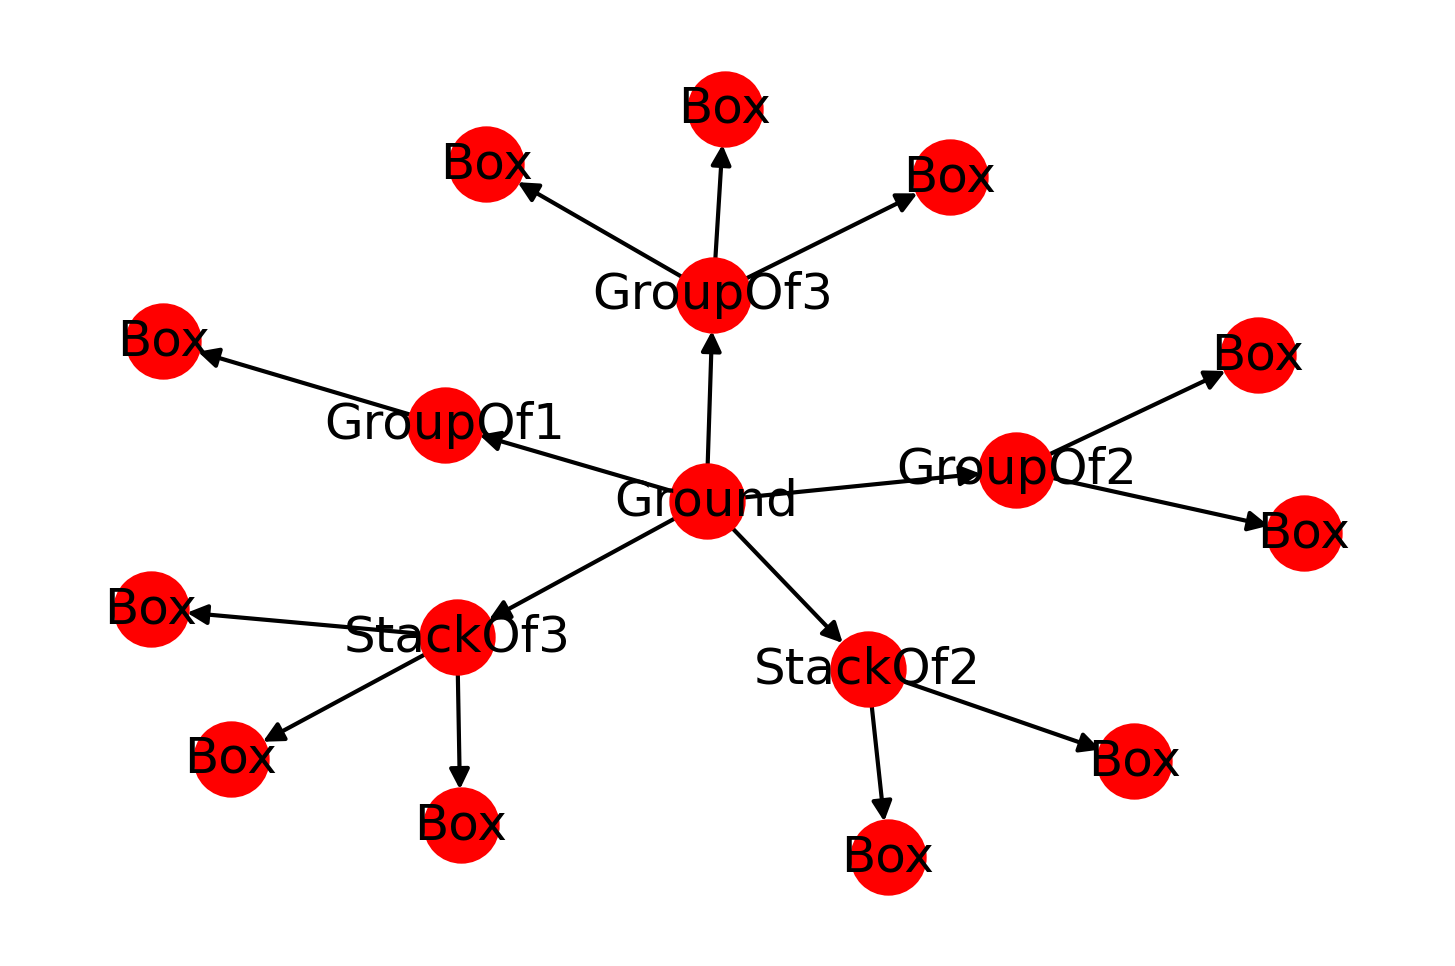

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneTree.make_meta_scene_tree(Ground())
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

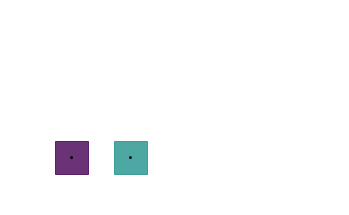

In [7]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)
print(observed_trees[0].nodes)
draw_boxes(observed_trees[2])

## I'm an idiot and rederive MPM
Top-down sampling approach: starting by defining an "observation likelihood" function $p(o | t)$ (observations $o$, proposed tree $t$. Scenes with the wrong number of boxes get -inf scores; scenes with the right number get scored based on distance. This is the density of an observation process where all the boxes in the underlying tree produce boxes with small noise around their generated location (have to deal with generated-to-observed box correspondences, though -- either evaluate them all or take the best one and claim the others don't contribute?); maybe this observation process should get formalized + included in the generative scene spec if this approach is what I go with moving forward.

Sample trees from the prior $p(t)$, likelihood is an evaluation of $p(o | t)$. If we want to draw samples from $p(t | o) = \dfrac{p(o, t)}{p(o)} = \dfrac{p(o | t) p(t)}{p(o)}$, treat it as an importance sampled population; I think it'll come out to drawing random samples from the generated pool with prob $\dfrac{p(o, t_j)}{\sum_i p(o, t_i)}$ for sampled tree $i$.

Or we could interleave with local search: tree "jumps" fit into MCMC, where the MH acceptance $a = min(1, \dfrac{p(t' | o)}{p(t | o)}\dfrac{p(t)}{p(t')})$ (the forward and reverse transition probabilities come from just sampling the tree proposals from their priors), which I think cancels down to $a = min(1, \dfrac{p(o | t')}{p(o | t)})$. This feels like SMC? I think we can interleave that proposal with local fixed-structure MCMC steps using a drift or HMC proposal.

Wait, I'm an idiot, this is just MPM again. Doh

## Top-down parsing with neural conditionally-transformed grammars
OK, explicitly non-MPM take: what if we lots of random sampling from the prior (or another proposal density) over tree structures to build a (probabilistically complete) library of topologies, but we only accept/reject them based on whether they are *feasible* w.r.t. our observed set of objects. (The density of each is $p(t_{fixed})$ normalized by the sum of densities of trees in the library, I think.) Then, for each one, we run MCMC or VI to get the posterior of the continuous variables given the fixed tree structure. Then we can reconstruct the density for the whole distribution by combining $p(t_{fixed} | o)p(t_{continuous} | o))$.

An advantage here is that we could try to **train neural proposals for proposal densities over trees** (by having the neural part consume the observed objects and produce altered grammar parameters) -- this may make it possible to sample relatively exhaustive topology libraries with relatively low cost. (It'd be trained, I hope, to not only sample feasible topologies, but sample ones that will ultimately have high likelihood in the full posterior.) Rather than trusting hybrid MCMC to traverse the space of trees like MPM, we instead try to build an exhaustive set of the interesting structure up-front. (This is maybe a good fit for us -- we have shallower grammars than MPM did.) But we'll scale very poorly because of that; we might have to be very careful about grammar design to not scale poorly. And we're asking the neural proposal part to work serious miracles.

Approach that leverages meta-scene-tree? Mixed-integer something? With a highly constrained spatial grammar, that might be possible...

## Bottom-up parsing with neural recognizers:
Bottom-up parsing: create a proposal function $q(t | o)$ that takes a set of observed nodes and spits out a completed tree (with reported density). Starting from a tree with just the observed nodes (with their attributes set):
1) For all candidate nodes to add or add children to, build the set of unclaimed children that could be added to them.
2) Select node to add (or add children to) with prob $node_i ~ p_{select}(node)$.
3) Get the parameters for proposal distributions for the inclusion of each child (as independent Bernoulli trials), and for the setting of the new node continuous parameters if they're not already set, from neural models. and draw from both (rejection sampling infeasible draws).
4) Add the children (and new node and its parameters, whatever is new) to the tree and repeat until no orphans are left or we hit an iteration limit.
5) The resulting density $q(t | o)$ is the product of densities for each selection and random draw. 

Neural models are trained directly supervised on data from trees drawn from the prior.

You can imagine that, starting from a set of observed nodes, there's a tree of decisions you can make, with leaves being resulting parsed trees. The proposal density of a tree is the product of probabilities of each branching decision made; I'm pretty sure this proposal density is properly normalized as long as each component proposal density is normalized. (You *can't* compare proposal densities between resulting trees of different structure, though, since the set of variables changes! Imagine one of those branches has a continuous variable with a tightly peaked Gaussian, and the other branch doesn't have that variable -- the Gaussian might inflate or deflate the proposal density at the proposal compared to the other branch. But the integration over all proposal densities is still reasonable, and you can compare e.g. the proposal density and the joint $p(t, o)$ at a point since the trees have the same structure.)